# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

Bank Marketing Data - A Decision Tree Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1a-nyAPNPiVh-Xb2Pu2t2p-BhSvHJS0pO"></center>


## 1.2 Install, load libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 145 kB 30.0 MB/s 
     |████████████████████████████████| 181 kB 34.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=9d047e7c697ad78d8654717e3af4af12d95aeabca2cb2be1ffc637ab9049b22d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Holdout Configuration

In [ ]:
# global variables

# ratio used to split train and validation data
val_size = 0.20

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "y"

# name of the input artifact
artifact_input_name = "mlops_ivan/decision_tree_bank/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="decision_tree_bank", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


07-06-2022 19:02:51 Downloading and reading train artifact
07-06-2022 19:02:52 Spliting data into train/val


In [ ]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

07-06-2022 19:02:52 x train: (25317, 16)
07-06-2022 19:02:52 y train: (25317,)
07-06-2022 19:02:52 x val: (6330, 16)
07-06-2022 19:02:52 y val: (6330,)


## 1.4 Data preparation

**Data preparation** may be the most important part of a machine learning project. 

```
It is the most time-consuming part, although it seems to be the least discussed topic. 
```

**Data preparation** sometimes referred to as **data preprocessing**, is the act of transforming raw data into a form that is appropriate for modeling. 

Machine learning algorithms require input data to be numbered, and most algorithm implementations maintain this expectation. As such, **if your data contains data types and values that are not numbers, such as labels, you will need to change the data into numbers**. Further, specific machine learning algorithms have expectations regarding the data types, scale, probability distribution, and relationships between input variables, and you may need to change the data to meet these expectations.

The philosophy of **data preparation** is to discover how to best expose the unknown underlying structure of the problem to the learning algorithms. This often requires **an iterative path of experimentation through a suite of different data preparation techniques** in order to discover what works well or best. The vast majority of the machine learning algorithms you may use on a project are years to decades old. **The implementation and application of the algorithms are well understood**. So much so that they are routine, with amazing, fully-featured open-source machine learning libraries like [scikit-learn](https://scikit-learn.org/stable/) in Python. 
```
The thing that is different from project to project is the data. 
```

You may be the first person (ever!) to use a specific dataset as the basis for a predictive modeling project. As such, the **preparation of the data** in order to best present it to the problem of the learning algorithms **is the primary task of any modern machine learning project**.

````
The challenge of data preparation is that each dataset is unique and different.
````

Datasets differ in the number of variables (tens, hundreds, thousands, or more), the types of the variables (numeric, nominal, ordinal, boolean), the scale of the variables, the drift in the values over time, and more. As such, this makes discussing data preparation a challenge. Either specific case studies are used, or focus is put on the general methods that can be used across projects. The result is that neither approach is explored.

### 1.4.1 Outlier Removal

In [ ]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

06-06-2022 11:56:14 Outlier Removal


In [ ]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

02-06-2022 13:22:36 x_train shape [original]: (25317, 16)
02-06-2022 13:22:36 x_train shape [outlier removal]: (24746, 16)


In [ ]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.4.2 Encoding Target Variable

In [ ]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

06-06-2022 11:56:29 Encoding Target Variable
06-06-2022 11:56:29 Classes [0, 1]: ['no' 'yes']


### 1.4.5 Using a full-pipeline

```
A reproducible pipeline is all you need
```

To follow the next cells' execution, it is important you re-run all cells at:
- Section 1.3
- Section 1.4.1
- Section 1.4.2

These steps are necessary to guarantee the raw ```train.csv``` is used.

#### 1.4.5.1 Feature Extractor

In [ ]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

In [ ]:
f_sel = copy_exception(x_train.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [ ]:
print( x_train.select_dtypes("object").columns.to_list())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [ ]:
f_sel = copy_exception(x_train.select_dtypes("int64").columns.to_list(), ["contact", "day"])
print(f_sel)

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
print( x_train.select_dtypes("int64").columns.to_list())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      exceptions = ["contact", "day", 'default', 'loan', 'marital']
      self.feature_names = copy_exception(feature_names, exceptions) 

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']
            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # Drop 'contact', as every participant has been contacted. 
            # df.drop('contact', axis=1, inplace=True)

            # day  : last contact day of the month
            # month: last contact month of year
            # Drop 'month' as they don't have any intrinsic meaning
            # df.drop('month', axis=1, inplace=True)
            df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # day  : last contact day of the month                  # adicionado
        # Drop 'day' as they don't have any intrinsic meaning
        # df.drop('day', axis=1, inplace=True)

        # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
        df.loc[df['pdays'] == -1, 'pdays'] = 10000

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,month,poutcome
15817,blue-collar,married,secondary,no,yes,no,jun,unknown
11478,services,married,secondary,no,yes,yes,may,unknown
16771,management,single,tertiary,no,no,no,aug,unknown
29487,management,single,tertiary,no,no,yes,jul,unknown
2762,admin.,single,secondary,no,yes,no,aug,unknown


In [ ]:
# df.poutcome.unique()
df.default.value_counts()

no     24309
yes      437
Name: default, dtype: int64

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,duration,campaign,pdays,previous
15817,49,-581,123,5,-1,0
11478,58,1667,85,1,-1,0
16771,31,98,69,2,-1,0
29487,30,47,11,17,-1,0
2762,33,344,103,4,-1,0


#### 1.4.5.2 Handling Categorical Features

In [ ]:
x_train.month.unique()

array(['jun', 'may', 'aug', 'jul', 'feb', 'nov', 'apr', 'mar', 'oct',
       'dec', 'jan', 'sep'], dtype=object)

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
15817,blue-collar,married,secondary,no,yes,no,unknown,jun,unknown
11478,services,married,secondary,no,yes,yes,unknown,may,unknown
16771,management,single,tertiary,no,no,no,cellular,aug,unknown
29487,management,single,tertiary,no,no,yes,cellular,jul,unknown
2762,admin.,single,secondary,no,yes,no,cellular,aug,unknown


In [ ]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
15817,blue-collar,married,secondary,no,yes,no,unknown,2st,unknown
11478,pink-collar,married,secondary,no,yes,yes,unknown,2st,unknown
16771,white-collar,single,tertiary,no,no,no,cellular,3st,unknown
29487,white-collar,single,tertiary,no,no,yes,cellular,3st,unknown
2762,white-collar,single,secondary,no,yes,no,cellular,3st,unknown


In [ ]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [ ]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
default      2
housing      2
loan         2
contact      3
month        4
poutcome     3
dtype: int64

#### 1.4.5.3 Handling Numerical Features

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,day,duration,campaign,pdays,previous
15817,49,-581,3,123,5,-1,0
11478,58,1667,6,85,1,-1,0
16771,31,98,11,69,2,-1,0
29487,30,47,31,11,17,-1,0
2762,33,344,20,103,4,-1,0


In [ ]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[  0.7804613 ,  -0.6969334 ,  -1.54805873, ...,   0.7462383 ,
        105.36453261,  -0.29247537],
       [  1.64043951,   0.11847936,  -1.18638708, ...,  -0.58364399,
        105.36453261,  -0.29247537],
       [ -0.93949514,  -0.45064102,  -0.58360099, ...,  -0.25117342,
        105.36453261,  -0.29247537],
       ...,
       [  1.73599265,   0.46162014,  -1.3069443 , ...,  -0.58364399,
        105.36453261,  -0.29247537],
       [ -0.46172946,  -0.40711365,  -1.42750152, ...,   1.07870888,
        105.36453261,  -0.29247537],
       [ -1.22615454,  -0.16299764,   1.34531449, ...,  -0.58364399,
        105.36453261,  -0.29247537]])

In [ ]:
df_num.shape

(24746, 7)

In [ ]:
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.4.5.4 Data Preparation Pipeline

In [ ]:
print(x_train.select_dtypes("object").columns.to_list())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [ ]:
print(x_train.select_dtypes("int64").columns.to_list())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [ ]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_blue-collar,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_divorced,marital_married,marital_single,...,month_4st,poutcome_failure,poutcome_success,poutcome_unknown,age,balance,duration,campaign,pdays,previous
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,49.0,-581.0,123.0,5.0,10000.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,58.0,1667.0,85.0,1.0,10000.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,31.0,98.0,69.0,2.0,10000.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,30.0,47.0,11.0,17.0,10000.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,33.0,344.0,103.0,4.0,10000.0,0.0


In [ ]:
print(df.columns.to_list())

['job_blue-collar', 'job_entrepreneur', 'job_other', 'job_pink-collar', 'job_self-employed', 'job_technician', 'job_white-collar', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_1st', 'month_2st', 'month_3st', 'month_4st', 'poutcome_failure', 'poutcome_success', 'poutcome_unknown', 'age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
print(new_data.shape)

(24746, 28)


## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline
- le (label encoder object used to encode the target variable)

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier(random_state=41, max_depth=6)) # random_state=41, max_depth=6
                         ]
                )

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

06-06-2022 13:52:38 Training
06-06-2022 13:52:38 Infering
06-06-2022 13:52:38 Evaluation metrics
06-06-2022 13:52:38 Accuracy: 0.8949447077409163
06-06-2022 13:52:38 Precision: 0.5935162094763092
06-06-2022 13:52:38 Recall: 0.3216216216216216
06-06-2022 13:52:38 F1: 0.4171779141104295


In [ ]:
dt6_score_train = pipe.score(x_train, y_train)
print("Training score: ",dt6_score_train)
dt6_score_test = pipe.score(x_val, y_val)
print("Testing score: ",dt6_score_test)

Training score:  0.9117433120504324
Testing score:  0.8962085308056872


In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

02-06-2022 13:01:04 Infering Bias
02-06-2022 13:01:04 Bias Evaluation metrics
02-06-2022 13:01:04 Bias Accuracy: 0.9117433120504324
02-06-2022 13:01:04 Bias Precision: 0.6596548004314995
02-06-2022 13:01:04 Bias Recall: 0.44056195965417866
02-06-2022 13:01:04 Bias F1: 0.5282937365010799


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      5590
           1       0.58      0.42      0.49       740

    accuracy                           0.90      6330
   macro avg       0.75      0.69      0.71      6330
weighted avg       0.89      0.90      0.89      6330



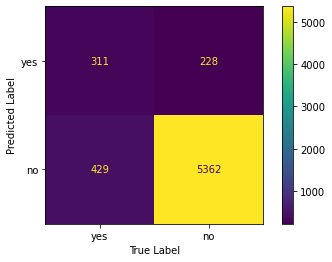

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

02-06-2022 13:01:16 Uploading figures


In [ ]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([0.        , 0.00082439, 0.        , 0.        , 0.        ,
       0.        , 0.00102848, 0.        , 0.00242335, 0.00288522,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03895655, 0.        , 0.00724264, 0.        , 0.02655247,
       0.00402514, 0.        , 0.00451354, 0.00340804, 0.        ,
       0.26102555, 0.        , 0.06189763, 0.01328175, 0.00905267,
       0.54103622, 0.00518614, 0.01555583, 0.00110441])

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown']

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous']

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
# wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [ ]:
# Plot the importance of columns
# wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
# wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
#                                    full_pipeline_preprocessing.transform(x_train),
#                                    y_train,
#                                    full_pipeline_preprocessing.transform(x_val),
#                                    y_val)

In [ ]:
# ROC curve
# predict_proba = pipe.predict_proba(x_val)
# wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

Acc,0.89621
F1,0.48632
Precision,0.57699
Recall,0.42027


## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [ ]:
# global seed
seed = 41

In [ ]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
            },
        "max_depth": {
            "values": [5, 6, 7]
            },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="decision_tree_bank", entity="mlops_ivan")

Create sweep with ID: imnxzeik
Sweep URL: https://wandb.ai/mlops_ivan/decision_tree_bank/sweeps/imnxzeik


In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__max_depth": run.config.max_depth})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=24)

wandb: Agent Starting Run: n3kc04s9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 6
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:02:37 Training
02-06-2022 13:02:37 Infering
02-06-2022 13:02:37 Evaluation metrics
02-06-2022 13:02:37 Accuracy: 0.8962085308056872
02-06-2022 13:02:37 Precision: 0.5769944341372912
02-06-2022 13:02:37 Recall: 0.42027027027027025
02-06-2022 13:02:37 F1: 0.48631743549648154


Accuracy,0.89621
F1,0.48632
Precision,0.57699
Recall,0.42027


wandb: Agent Starting Run: 5yi3dfo9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:02:52 Training
02-06-2022 13:02:52 Infering
02-06-2022 13:02:52 Evaluation metrics
02-06-2022 13:02:52 Accuracy: 0.8955766192733018
02-06-2022 13:02:52 Precision: 0.6321070234113713
02-06-2022 13:02:52 Recall: 0.2554054054054054
02-06-2022 13:02:52 F1: 0.3638113570741097


Accuracy,0.89558
F1,0.36381
Precision,0.63211
Recall,0.25541


wandb: Agent Starting Run: aa0dr1dh with config:
wandb: 	criterion: gini
wandb: 	max_depth: 6
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:03:07 Training
02-06-2022 13:03:07 Infering
02-06-2022 13:03:07 Evaluation metrics
02-06-2022 13:03:07 Accuracy: 0.8924170616113745
02-06-2022 13:03:07 Precision: 0.6439024390243903
02-06-2022 13:03:07 Recall: 0.1783783783783784
02-06-2022 13:03:07 F1: 0.27936507936507937


Accuracy,0.89242
F1,0.27937
Precision,0.6439
Recall,0.17838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pxj08kb9 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 6
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:03:27 Training
02-06-2022 13:03:28 Infering
02-06-2022 13:03:28 Evaluation metrics
02-06-2022 13:03:28 Accuracy: 0.8924170616113745
02-06-2022 13:03:28 Precision: 0.6439024390243903
02-06-2022 13:03:28 Recall: 0.1783783783783784
02-06-2022 13:03:28 F1: 0.27936507936507937


Accuracy,0.89242
F1,0.27937
Precision,0.6439
Recall,0.17838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dypcyitm with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:03:48 Training
02-06-2022 13:03:49 Infering
02-06-2022 13:03:49 Evaluation metrics
02-06-2022 13:03:49 Accuracy: 0.8987361769352291
02-06-2022 13:03:49 Precision: 0.6523076923076923
02-06-2022 13:03:49 Recall: 0.2864864864864865
02-06-2022 13:03:49 F1: 0.39812206572769954


Accuracy,0.89874
F1,0.39812
Precision,0.65231
Recall,0.28649


wandb: Agent Starting Run: 4n7df8yc with config:
wandb: 	criterion: gini
wandb: 	max_depth: 7
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:04:05 Training
02-06-2022 13:04:05 Infering
02-06-2022 13:04:05 Evaluation metrics
02-06-2022 13:04:05 Accuracy: 0.8966824644549763
02-06-2022 13:04:05 Precision: 0.6327160493827161
02-06-2022 13:04:05 Recall: 0.27702702702702703
02-06-2022 13:04:05 F1: 0.38533834586466165


Accuracy,0.89668
F1,0.38534
Precision,0.63272
Recall,0.27703


wandb: Agent Starting Run: qgll81ef with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 6
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:04:20 Training
02-06-2022 13:04:20 Infering
02-06-2022 13:04:20 Evaluation metrics
02-06-2022 13:04:20 Accuracy: 0.8960505529225908
02-06-2022 13:04:20 Precision: 0.6485507246376812
02-06-2022 13:04:20 Recall: 0.2418918918918919
02-06-2022 13:04:20 F1: 0.3523622047244095


Accuracy,0.89605
F1,0.35236
Precision,0.64855
Recall,0.24189


wandb: Agent Starting Run: axtimzd3 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:04:35 Training
02-06-2022 13:04:35 Infering
02-06-2022 13:04:35 Evaluation metrics
02-06-2022 13:04:35 Accuracy: 0.8988941548183255
02-06-2022 13:04:35 Precision: 0.6184834123222749
02-06-2022 13:04:35 Recall: 0.3527027027027027
02-06-2022 13:04:35 F1: 0.44922547332185886


Accuracy,0.89889
F1,0.44923
Precision,0.61848
Recall,0.3527


wandb: Agent Starting Run: 2al6bhaf with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 6
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:04:53 Training
02-06-2022 13:04:53 Infering
02-06-2022 13:04:53 Evaluation metrics
02-06-2022 13:04:53 Accuracy: 0.8960505529225908
02-06-2022 13:04:53 Precision: 0.6485507246376812
02-06-2022 13:04:53 Recall: 0.2418918918918919
02-06-2022 13:04:53 F1: 0.3523622047244095


Accuracy,0.89605
F1,0.35236
Precision,0.64855
Recall,0.24189


wandb: Agent Starting Run: l5w23ga9 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:05:07 Training
02-06-2022 13:05:07 Infering
02-06-2022 13:05:07 Evaluation metrics
02-06-2022 13:05:07 Accuracy: 0.8987361769352291
02-06-2022 13:05:07 Precision: 0.6523076923076923
02-06-2022 13:05:07 Recall: 0.2864864864864865
02-06-2022 13:05:07 F1: 0.39812206572769954


Accuracy,0.89874
F1,0.39812
Precision,0.65231
Recall,0.28649


wandb: Agent Starting Run: r89bx1kb with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:05:24 Training
02-06-2022 13:05:24 Infering
02-06-2022 13:05:24 Evaluation metrics
02-06-2022 13:05:24 Accuracy: 0.8973143759873617
02-06-2022 13:05:24 Precision: 0.6
02-06-2022 13:05:24 Recall: 0.36486486486486486
02-06-2022 13:05:24 F1: 0.453781512605042


Accuracy,0.89731
F1,0.45378
Precision,0.6
Recall,0.36486


wandb: Agent Starting Run: t2xcah07 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:05:37 Training
02-06-2022 13:05:37 Infering
02-06-2022 13:05:38 Evaluation metrics
02-06-2022 13:05:38 Accuracy: 0.8971563981042654
02-06-2022 13:05:38 Precision: 0.5986696230598669
02-06-2022 13:05:38 Recall: 0.36486486486486486
02-06-2022 13:05:38 F1: 0.4534005037783375


Accuracy,0.89716
F1,0.4534
Precision,0.59867
Recall,0.36486


wandb: Agent Starting Run: 0eemrjd9 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:05:55 Training
02-06-2022 13:05:55 Infering
02-06-2022 13:05:55 Evaluation metrics
02-06-2022 13:05:55 Accuracy: 0.8988941548183255
02-06-2022 13:05:55 Precision: 0.6184834123222749
02-06-2022 13:05:55 Recall: 0.3527027027027027
02-06-2022 13:05:55 F1: 0.44922547332185886


Accuracy,0.89889
F1,0.44923
Precision,0.61848
Recall,0.3527


wandb: Agent Starting Run: qqaa9wto with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 6
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:06:09 Training
02-06-2022 13:06:10 Infering
02-06-2022 13:06:10 Evaluation metrics
02-06-2022 13:06:10 Accuracy: 0.8960505529225908
02-06-2022 13:06:10 Precision: 0.6485507246376812
02-06-2022 13:06:10 Recall: 0.2418918918918919
02-06-2022 13:06:10 F1: 0.3523622047244095


Accuracy,0.89605
F1,0.35236
Precision,0.64855
Recall,0.24189


wandb: Agent Starting Run: 3vnxebel with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 6
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:06:26 Training
02-06-2022 13:06:27 Infering
02-06-2022 13:06:27 Evaluation metrics
02-06-2022 13:06:27 Accuracy: 0.8976303317535546
02-06-2022 13:06:27 Precision: 0.5982905982905983
02-06-2022 13:06:27 Recall: 0.3783783783783784
02-06-2022 13:06:27 F1: 0.4635761589403974


Accuracy,0.89763
F1,0.46358
Precision,0.59829
Recall,0.37838


wandb: Agent Starting Run: 195yf0yq with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:06:40 Training
02-06-2022 13:06:40 Infering
02-06-2022 13:06:40 Evaluation metrics
02-06-2022 13:06:40 Accuracy: 0.8936808846761454
02-06-2022 13:06:40 Precision: 0.6558139534883721
02-06-2022 13:06:40 Recall: 0.19054054054054054
02-06-2022 13:06:40 F1: 0.2952879581151832


Accuracy,0.89368
F1,0.29529
Precision,0.65581
Recall,0.19054


wandb: Agent Starting Run: ld025u5j with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:06:57 Training
02-06-2022 13:06:58 Infering
02-06-2022 13:06:58 Evaluation metrics
02-06-2022 13:06:58 Accuracy: 0.8936808846761454
02-06-2022 13:06:58 Precision: 0.6558139534883721
02-06-2022 13:06:58 Recall: 0.19054054054054054
02-06-2022 13:06:58 F1: 0.2952879581151832


Accuracy,0.89368
F1,0.29529
Precision,0.65581
Recall,0.19054


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0i9mhdlm with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 5
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:07:21 Training
02-06-2022 13:07:21 Infering
02-06-2022 13:07:21 Evaluation metrics
02-06-2022 13:07:21 Accuracy: 0.8988941548183255
02-06-2022 13:07:21 Precision: 0.6184834123222749
02-06-2022 13:07:21 Recall: 0.3527027027027027
02-06-2022 13:07:21 F1: 0.44922547332185886


Accuracy,0.89889
F1,0.44923
Precision,0.61848
Recall,0.3527


wandb: Agent Starting Run: f94it2of with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:07:36 Training
02-06-2022 13:07:37 Infering
02-06-2022 13:07:37 Evaluation metrics
02-06-2022 13:07:37 Accuracy: 0.8955766192733018
02-06-2022 13:07:37 Precision: 0.5831578947368421
02-06-2022 13:07:37 Recall: 0.37432432432432433
02-06-2022 13:07:37 F1: 0.4559670781893004


Accuracy,0.89558
F1,0.45597
Precision,0.58316
Recall,0.37432


wandb: Agent Starting Run: b9z5gb23 with config:
wandb: 	criterion: gini
wandb: 	max_depth: 5
wandb: 	model: 2
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:07:52 Training
02-06-2022 13:07:52 Infering
02-06-2022 13:07:53 Evaluation metrics
02-06-2022 13:07:53 Accuracy: 0.8955766192733018
02-06-2022 13:07:53 Precision: 0.6321070234113713
02-06-2022 13:07:53 Recall: 0.2554054054054054
02-06-2022 13:07:53 F1: 0.3638113570741097


Accuracy,0.89558
F1,0.36381
Precision,0.63211
Recall,0.25541


wandb: Agent Starting Run: sl4hasht with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:08:09 Training
02-06-2022 13:08:09 Infering
02-06-2022 13:08:09 Evaluation metrics
02-06-2022 13:08:09 Accuracy: 0.8987361769352291
02-06-2022 13:08:09 Precision: 0.6523076923076923
02-06-2022 13:08:09 Recall: 0.2864864864864865
02-06-2022 13:08:09 F1: 0.39812206572769954


Accuracy,0.89874
F1,0.39812
Precision,0.65231
Recall,0.28649


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4qw5mbu3 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: random


02-06-2022 13:08:36 Training
02-06-2022 13:08:36 Infering
02-06-2022 13:08:36 Evaluation metrics
02-06-2022 13:08:36 Accuracy: 0.8987361769352291
02-06-2022 13:08:36 Precision: 0.6523076923076923
02-06-2022 13:08:36 Recall: 0.2864864864864865
02-06-2022 13:08:36 F1: 0.39812206572769954


Accuracy,0.89874
F1,0.39812
Precision,0.65231
Recall,0.28649


wandb: Agent Starting Run: 5v01h5y0 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 6
wandb: 	model: 0
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:08:55 Training
02-06-2022 13:08:55 Infering
02-06-2022 13:08:55 Evaluation metrics
02-06-2022 13:08:55 Accuracy: 0.8976303317535546
02-06-2022 13:08:55 Precision: 0.5982905982905983
02-06-2022 13:08:55 Recall: 0.3783783783783784
02-06-2022 13:08:55 F1: 0.4635761589403974


Accuracy,0.89763
F1,0.46358
Precision,0.59829
Recall,0.37838


wandb: Agent Starting Run: 6mdtk6g1 with config:
wandb: 	criterion: entropy
wandb: 	max_depth: 7
wandb: 	model: 1
wandb: 	random_state: 41
wandb: 	splitter: best


02-06-2022 13:09:15 Training
02-06-2022 13:09:15 Infering
02-06-2022 13:09:15 Evaluation metrics
02-06-2022 13:09:15 Accuracy: 0.8955766192733018
02-06-2022 13:09:15 Precision: 0.5831578947368421
02-06-2022 13:09:15 Recall: 0.37432432432432433
02-06-2022 13:09:15 F1: 0.4559670781893004


Accuracy,0.89558
F1,0.45597
Precision,0.58316
Recall,0.37432


## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
# run = wandb.init(project="decision_tree_bank", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 1})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'random'})
pipe.set_params(**{"classifier__max_depth": 6})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

02-06-2022 13:25:18 Training
02-06-2022 13:25:19 Infering
02-06-2022 13:25:19 Evaluation metrics
02-06-2022 13:25:19 Accuracy: 0.8960505529225908
02-06-2022 13:25:19 Precision: 0.6485507246376812
02-06-2022 13:25:19 Recall: 0.2418918918918919
02-06-2022 13:25:19 F1: 0.3523622047244095


In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown']

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_blue-collar',
 'job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_1st',
 'month_2st',
 'month_3st',
 'month_4st',
 'poutcome_failure',
 'poutcome_success',
 'poutcome_unknown',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous']

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

wandb: 
wandb: Plotting BestModel.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


## 1.8 Export the best model

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

02-06-2022 13:28:06 Dumping the artifacts to disk


['target_encoder']

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

02-06-2022 13:28:10 Logging model artifact


In [ ]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

02-06-2022 13:28:14 Logging target enconder artifact


In [ ]:
run.finish()

Acc,0.89605
F1,0.35236
Precision,0.64855
Recall,0.24189
